In [1]:
import sys
import sklearn

import tensorflow as tf
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

In [35]:
tf.__version__

'2.9.0'

In [2]:
def plot_image(image):
    plt.imshow(image, cmap= 'binary')
    plt.axis("off")

# PCA with a linear Autoencoder

In [3]:
np.random.seed(42)

def generate_3d_data(m, w1=0.1, w2 =0.3, noise=0.1):
    angles= np.random.rand(m)*3*np.pi/ 2- 0.5
    data = np.empty((m,3))
    data[:,0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m)/2
    data[:,1] = np.sin(angles)* 0.7 + noise * np.random.randn(m)/2
    data[:,2] = data[:,0] * w1 + data[:,1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)
    

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [6]:
history=autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 1s 2ms/step - loss: 0.2727
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 0.1069
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 0.1126
Epoch 4/20
2/2 [==============================] - 0s 1ms/step - loss: 0.1763
Epoch 5/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0846
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0675
Epoch 7/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0626
Epoch 8/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0522
Epoch 9/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0228
Epoch 10/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 11/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0083
Epoch 12/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 13/20
2/2 [==============================] - 0s 1ms/step - loss: 0.

In [7]:
codings=encoder.predict(X_train)

2/2 [==============================] - 0s 1ms/step


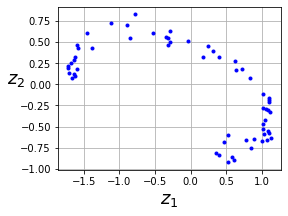

In [8]:
fig=plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:,1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

# Stacked Autoencoder

In [9]:
(X_train_full, y_train_full), (X_test, y_test)=keras.datasets.fashion_mnist.load_data()
X_train_full=X_train_full.astype(np.float32)/255
X_test =X_test.astype(np.float32)/255
X_train, X_valid=X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid=y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation= 'selu'),
    keras.layers.Dense(30, activation= 'selu')])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation= 'selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation= 'sigmoid'),
    keras.layers.Reshape([28,28])])

stacked_ae=keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history=stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3172 - val_rounded_accuracy: 0.8992
Epoch 2/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9200
Epoch 3/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2989 - val_rounded_accuracy: 0.9191
Epoch 4/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9284
Epoch 5/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [==================

In [13]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions=model.predict(images[:n_images])
    fig=plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1+n_images+image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 40ms/step


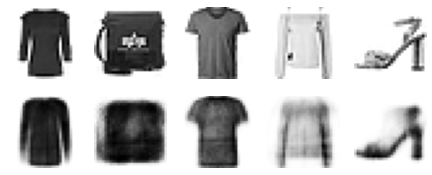

In [14]:
show_reconstructions(stacked_ae)

# Visualizing Fashion MNIST

In [15]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed=stacked_encoder.predict(X_valid)
tsne=TSNE()
X_valid_2D=tsne.fit_transform(X_valid_compressed)
X_valid_2D=(X_valid_2D - X_valid_2D.min())/(X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 519us/step


/home/tuffy/venvs/.tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/tuffy/venvs/.tf/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(-0.05, 1.05, 0.03766117952764034, 0.9297710437327623)

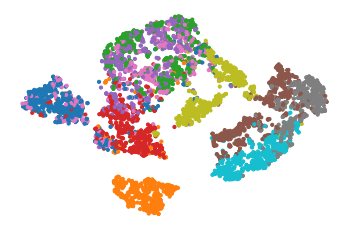

In [16]:
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c=y_valid, s=10, cmap="tab10")
plt.axis('off')

(-0.05, 1.05, 0.03766117952764034, 0.9297710437327623)

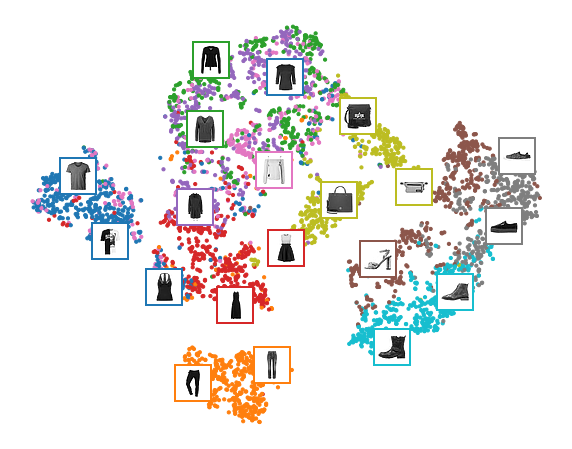

In [18]:
plt.figure(figsize=(10,8))
cmap=plt.cm.tab10
plt.scatter(X_valid_2D[:,0], X_valid_2D[:,1], c= y_valid, s=10, cmap=cmap)
image_positions=np.array([[1.,1.]])
for index, position in enumerate(X_valid_2D):
    dist=np.sum((position - image_positions)** 2, axis=1)
    if np.min(dist) > 0.02:
        image_positions=np.r_[image_positions, [position]]
        imagebox=mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={'edgecolor':cmap(y_valid[index]), "lw":2})
        plt.gca().add_artist(imagebox)
plt.axis('off')


## Tying weights

In [19]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense =dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases=self.add_weight(name='bias', 
                                   shape=[self.dense.input_shape[-1]],
                                   initializer='zeros')
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
    

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation='selu')
dense_2 = keras.layers.Dense(30, activation='selu')

tied_encoder= keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    dense_1,
    dense_2
])

tied_decoder= keras.models.Sequential([
    DenseTranspose(dense_2, activation='selu'),
    DenseTranspose(dense_1, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

tied_ae =keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.SGD(learning_rate=1.5),
                metrics=[rounded_accuracy])
history=tied_ae.fit(X_train, X_train, epochs=10,
                    validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3075 - val_rounded_accuracy: 0.9090
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2975 - rounded_accuracy: 0.9223 - val_loss: 0.2956 - val_rounded_accuracy: 0.9283
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3014 - val_rounded_accuracy: 0.9091
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9331
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2866 - rounded_accuracy: 0.9323 - val_loss: 0.2865 - val_rounded_accuracy: 0.9334
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2850 - rounded_accuracy: 0.9339 - val_loss: 0.2863 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 37ms/step


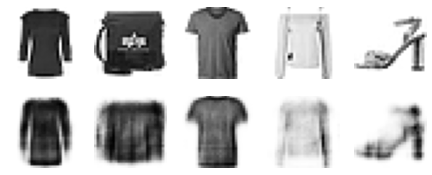

In [23]:
show_reconstructions(tied_ae)

## Training one Autoencoder at a Time

In [24]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                     n_epochs=10, output_activation=None, metrics=None):
    n_inputs =X_train.shape[-1]
    encoder=keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation='selu', input_shape =[n_inputs])
    ])
    decoder =keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder =keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics =metrics)
    autoencoder.fit(X_train, X_train, epochs = n_epochs,
                    validation_data =(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

K=keras.backend
X_train_flat= K.batch_flatten(X_train)
X_valid_flat= K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation='sigmoid',
    metrics=[rounded_accuracy])
enc2, dec2, _,_ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse",
    keras.optimizers.SGD(learning_rate=0.05), output_activation='selu')


Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2891 - rounded_accuracy: 0.9341 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [29]:
stacked_ae_1_by_1 =keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28,28])
])

1/1 [==============================] - 0s 37ms/step


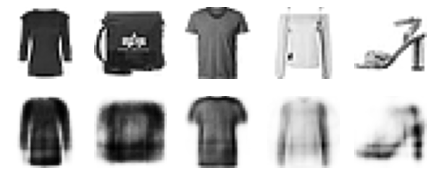

In [30]:
show_reconstructions(stacked_ae_1_by_1)

In [31]:
stacked_ae_1_by_1.compile(loss='binary_crossentropy', 
                          optimizer= keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history=stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, 
                              validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9349
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 38ms/step


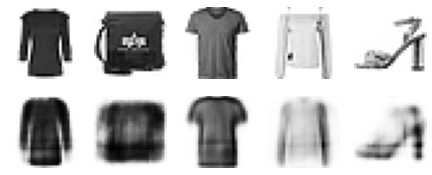

In [32]:
show_reconstructions(stacked_ae_1_by_1)

## Using Convolutional Layers Instead of Dense Layers

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder= keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape =[28,28]),
    keras.layers.Conv2D(16,kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32,kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64,kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2)    
])
conv_decoder= keras.models.Sequential([
    keras.layers.Conv2DTranspose(32,kernel_size=3, strides=2, padding='VALID', activation='selu', 
                                 input_shape=[3,3,64]),
    keras.layers.Conv2DTranspose(16,kernel_size=3,strides=2, padding='SAME', activation='selu'),
    keras.layers.Conv2DTranspose(1,kernel_size=3,strides=2, padding='SAME', activation='sigmoid'),
    keras.layers.Reshape([28,28])
])
conv_ae=keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history=conv_ae.fit(X_train, X_train, epochs=5, 
                   validation_data=(X_valid, X_valid))

Epoch 1/5


2023-08-02 05:07:31.121804: E tensorflow/stream_executor/cuda/cuda_dnn.cc:389] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-08-02 05:07:31.122025: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'sequential_18/sequential_16/conv2d/Conv2D' defined at (most recent call last):
    File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/local/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/local/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/local/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_59809/970449253.py", line 24, in <cell line: 24>
      history=conv_ae.fit(X_train, X_train, epochs=5,
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/tuffy/venvs/.tf/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_18/sequential_16/conv2d/Conv2D'
DNN library is not found.
	 [[{{node sequential_18/sequential_16/conv2d/Conv2D}}]] [Op:__inference_train_function_592247]

In [ ]:
conv_encoder.summary()
conv_decoder.summary()

In [ ]:
show_reconstructions(conv_ae)

# Recurrent Autoencoders

In [ ]:
recurrent_encoder=keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28,28]),
    keras.layers.LSTM(30)])
recurrent_decoder=keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28,actiation='sigmoid'))])
recurrent_ae =keras.models.Sequential([recurrent_encoder ,recurrent_decoder])
recurrent_ae.compile(loss='bianry_crossentropy', optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [ ]:
history= recurrent_ae.fit(X_train, X_train, epochs=10, validation_data= (X_valid, X_valid))

In [ ]:
show_reconstructions(recurrent_ae)

# Stacked denoising Autoencoder

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
denoising_encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')])
denoising_decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])])
denoising_ae =keras.models.Sequential([denoising_encoder ,denoising_decoder])
denoising_ae.compile(loss='bianry_crossentropy', optimizer=keras.optimizers.SGD(1.0),
                     metrics=[rounded_accuracy])

history= denoising_ae.fit(X_train, X_train, epochs=10, validation_data= (X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise= keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)
dropout_encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')])
dropout_decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])])
dropout_ae =keras.models.Sequential([dropout_encoder ,dropout_decoder])
dropout_ae.compile(loss='bianry_crossentropy', optimizer=keras.optimizers.SGD(1.0),
                     metrics=[rounded_accuracy])

history= dropout_ae.fit(X_train, X_train, epochs=10, validation_data= (X_valid, X_valid))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(denoising_ae, dropout(X_valid, training=True))

# Sparse Autoencoder

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='sigmoid')])
simple_decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])])
simple_ae =keras.models.Sequential([simple_encoder ,simple_decoder])
simple_ae.compile(loss='bianry_crossentropy', optimizer=keras.optimizers.SGD(1.0),
                     metrics=[rounded_accuracy])

history= simple_ae.fit(X_train, X_train, epochs=10, validation_data= (X_valid, X_valid))

In [ ]:
show_reconstructions(simple_ae)

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ =np.histogram(data, bins= bins)
    widths=bins[1:]-bins[:-1]
    x= bins[:-1]+ widths/2
    ax.bar(x, counts/len(data), width=width*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100*y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings=encoder(X_valid).numpy()
    activation_means=X_valid_codings.mean(axis=0)
    mean=activation_means.mean()
    bins=np.linspace(0,1,n_bins+1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10,3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label = "Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc= "upeer center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0,1,0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0,1,0, height])
    

In [ ]:
plot_activations_histgram(simple_encoder, height=0.35)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid'), 
    keras.layers.ActivityRegularization(l1=1e-3)])
sparse_l1_decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])])
sparse_l1_ae =keras.models.Sequential([sparse_l1_encoder ,sparse_l1_decoder])
sparse_l1_ae.compile(loss='bianry_crossentropy', optimizer=keras.optimizers.SGD(1.0),
                     metrics=[rounded_accuracy])

history= sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data= (X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_l1_ae)

In [ ]:
plot_activations_histgram(sparse_l1_encoder, height=1.)

In [ ]:
p=0.1
q=np.linspace(0.001, 0.999, 500)
kl_div=p*np.log(p/q) +(1-p)*np.log((1-p)/(1-q))
mse= (p-1)**2
mae=np.abs(p-q)
plt.plot([p,p], [0,0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label= "KL divergence")
plt.plot(q, mae, "g--", label= r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth =1, label= r"MAE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [ ]:
K=keras.backerd
kl_divergence = keras.lossses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target-0.1):
        self.weight=weight
        self.target=target
    def __call__(self, inputs):
        mean_activities= K.mean(inputs, axis=0)
        return self.weight*(
            kl_divergence(self.target, mean_activities) + 
            kl_divergence(1. - self.target, 1.- mean_activities))


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(300, activation='sigmoid', activity_regularizer=kld_reg)])
sparse_kl_decoder=keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])])
sparse_kl_ae =keras.models.Sequential([sparse_kl_encoder ,sparse_kl_decoder])
sparse_kl_ae.compile(loss='bianry_crossentropy', optimizer=keras.optimizers.SGD(1.0),
                     metrics=[rounded_accuracy])

history= sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data= (X_valid, X_valid))

In [ ]:
show_reconstructions(sparse_kl_ae)

In [ ]:
plot_activations_histgram(sparse_kl_encoder)

# Variational Autoencoder